# Final Exam: Load and analyze data from Polygon in real time

1. I noticed that buying/selling anytime that there were 2 or 3 consecutive returns in the same direction lead to rather ocsilatory profits, because it is a very common occurance to have 2/3 consecutive returns in the same direction. To pick out a stronger signal of returns, I decided to try to couple that strategy with a strategy of buying and selling when the returns cross the Bollinger bands constructed out of the moving averages of returns. In order to test these hypotheses, I calculated the profits/losses for just using the first strategy, using both strategies, and using only the latter strategy. It turns out that the profits/losses turned out better when only using the second strategy (Bollinger bands for the returns). I also tried 3 different levels of bolliinger bands for each experienmt (1.25, 1.5, and 1.75). Bollinger bands using 1.5 times the standard deviation ended up being the ideal way to get the best profits. 
2. My investment strategy was to buy/sell any time that the return value was outside the Bollinger bands that were created using the returns. 
3. The code that was used for analysis/strategy development based on histocal data is included towards the end of this file. Please note, this was dataset used to develop a strategy was not a complete 24 hours worth of data because of poor logistical planning on my part. 
4. Please note: I use the original formula for returns, so the first 6 minute checkpoint doesn't yeild any interesting results, because there is no previous price to compare with yet. 

In [15]:
# Import required libraries
import datetime
import time
from polygon import RESTClient
from sqlalchemy import create_engine 
from sqlalchemy import text
import pandas as pd
from math import sqrt
from math import isnan
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from math import floor

In [16]:
# The following 10 blocks of code define the classes for storing the the return data, for each
# currency pair.
        
# Define the AUDUSD_return class - each instance will store one row from the dataframe
class AUDUSD_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if AUDUSD_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - AUDUSD_return.last_price) / AUDUSD_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            AUDUSD_return.run_sum = 0
        else:
            # Increment the counter
            if AUDUSD_return.num < 5:
                AUDUSD_return.num += 1
            AUDUSD_return.run_sum += hist_return
        AUDUSD_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            AUDUSD_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            AUDUSD_return.run_sum -= pop_value
            avg = AUDUSD_return.run_sum/(AUDUSD_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(AUDUSD_return.run_squared_sum/(AUDUSD_return.num))
            self.std_return = std
            AUDUSD_return.run_sum_of_std += std
            AUDUSD_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            AUDUSD_return.run_sum_of_std -= pop_value
            avg_std = AUDUSD_return.run_sum_of_std/(AUDUSD_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [17]:
# Define the GBPEUR_return class - each instance will store one row from the dataframe
class GBPEUR_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if GBPEUR_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - GBPEUR_return.last_price) / GBPEUR_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            GBPEUR_return.run_sum = 0
        else:
            # Increment the counter
            if GBPEUR_return.num < 5:
                GBPEUR_return.num += 1
            GBPEUR_return.run_sum += hist_return
        GBPEUR_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            GBPEUR_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            GBPEUR_return.run_sum -= pop_value
            avg = GBPEUR_return.run_sum/(GBPEUR_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(GBPEUR_return.run_squared_sum/(GBPEUR_return.num))
            self.std_return = std
            GBPEUR_return.run_sum_of_std += std
            GBPEUR_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            GBPEUR_return.run_sum_of_std -= pop_value
            avg_std = GBPEUR_return.run_sum_of_std/(GBPEUR_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [18]:
# Define the USDCAD_return class - each instance will store one row from the dataframe
class USDCAD_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):

        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDCAD_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDCAD_return.last_price) / USDCAD_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDCAD_return.run_sum = 0
        else:
            # Increment the counter
            if USDCAD_return.num < 5:
                USDCAD_return.num += 1
            USDCAD_return.run_sum += hist_return
        USDCAD_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDCAD_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCAD_return.run_sum -= pop_value
            avg = USDCAD_return.run_sum/(USDCAD_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDCAD_return.run_squared_sum/(USDCAD_return.num))
            self.std_return = std
            USDCAD_return.run_sum_of_std += std
            USDCAD_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCAD_return.run_sum_of_std -= pop_value
            avg_std = USDCAD_return.run_sum_of_std/(USDCAD_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [19]:
# Define the USDJPY_return class - each instance will store one row from the dataframe
class USDJPY_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDJPY_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDJPY_return.last_price) / USDJPY_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDJPY_return.run_sum = 0
        else:
            # Increment the counter
            if USDJPY_return.num < 5:
                USDJPY_return.num += 1
            USDJPY_return.run_sum += hist_return
        USDJPY_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDJPY_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDJPY_return.run_sum -= pop_value
            avg = USDJPY_return.run_sum/(USDJPY_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDJPY_return.run_squared_sum/(USDJPY_return.num))
            self.std_return = std
            USDJPY_return.run_sum_of_std += std
            USDJPY_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDJPY_return.run_sum_of_std -= pop_value
            avg_std = USDJPY_return.run_sum_of_std/(USDJPY_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [20]:
# Define the USDMXN_return class - each instance will store one row from the dataframe
class USDMXN_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDMXN_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDMXN_return.last_price) / USDMXN_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDMXN_return.run_sum = 0
        else:
            # Increment the counter
            if USDMXN_return.num < 5:
                USDMXN_return.num += 1
            USDMXN_return.run_sum += hist_return
        USDMXN_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDMXN_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDMXN_return.run_sum -= pop_value
            avg = USDMXN_return.run_sum/(USDMXN_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDMXN_return.run_squared_sum/(USDMXN_return.num))
            self.std_return = std
            USDMXN_return.run_sum_of_std += std
            USDMXN_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDMXN_return.run_sum_of_std -= pop_value
            avg_std = USDMXN_return.run_sum_of_std/(USDMXN_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [21]:
# Define the EURUSD_return class - each instance will store one row from the dataframe
class EURUSD_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if EURUSD_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - EURUSD_return.last_price) / EURUSD_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            EURUSD_return.run_sum = 0
        else:
            # Increment the counter
            if EURUSD_return.num < 5:
                EURUSD_return.num += 1
            EURUSD_return.run_sum += hist_return
        EURUSD_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            EURUSD_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            EURUSD_return.run_sum -= pop_value
            avg = EURUSD_return.run_sum/(EURUSD_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(EURUSD_return.run_squared_sum/(EURUSD_return.num))
            self.std_return = std
            EURUSD_return.run_sum_of_std += std
            EURUSD_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            EURUSD_return.run_sum_of_std -= pop_value
            avg_std = EURUSD_return.run_sum_of_std/(EURUSD_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [22]:
# Define the USDCNY_return class - each instance will store one row from the dataframe
class USDCNY_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDCNY_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDCNY_return.last_price) / USDCNY_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDCNY_return.run_sum = 0
        else:
            # Increment the counter
            if USDCNY_return.num < 5:
                USDCNY_return.num += 1
            USDCNY_return.run_sum += hist_return
        USDCNY_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDCNY_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCNY_return.run_sum -= pop_value
            avg = USDCNY_return.run_sum/(USDCNY_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDCNY_return.run_squared_sum/(USDCNY_return.num))
            self.std_return = std
            USDCNY_return.run_sum_of_std += std
            USDCNY_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCNY_return.run_sum_of_std -= pop_value
            avg_std = USDCNY_return.run_sum_of_std/(USDCNY_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [23]:
# Define the USDCZK_return class - each instance will store one row from the dataframe
class USDCZK_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDCZK_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDCZK_return.last_price) / USDCZK_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDCZK_return.run_sum = 0
        else:
            # Increment the counter
            if USDCZK_return.num < 5:
                USDCZK_return.num += 1            
            USDCZK_return.run_sum += hist_return
        USDCZK_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDCZK_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCZK_return.run_sum -= pop_value
            avg = USDCZK_return.run_sum/(USDCZK_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDCZK_return.run_squared_sum/(USDCZK_return.num))
            self.std_return = std
            USDCZK_return.run_sum_of_std += std
            USDCZK_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDCZK_return.run_sum_of_std -= pop_value
            avg_std = USDCZK_return.run_sum_of_std/(USDCZK_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [24]:
# Define the USDPLN_return class - each instance will store one row from the dataframe
class USDPLN_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDPLN_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDPLN_return.last_price) / USDPLN_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDPLN_return.run_sum = 0
        else:
            # Increment the counter
            if USDPLN_return.num < 5:
                USDPLN_return.num += 1
            USDPLN_return.run_sum += hist_return
        USDPLN_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDPLN_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDPLN_return.run_sum -= pop_value
            avg = USDPLN_return.run_sum/(USDPLN_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDPLN_return.run_squared_sum/(USDPLN_return.num))
            self.std_return = std
            USDPLN_return.run_sum_of_std += std
            USDPLN_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDPLN_return.run_sum_of_std -= pop_value
            avg_std = USDPLN_return.run_sum_of_std/(USDPLN_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [25]:
# Define the USDINR_return class - each instance will store one row from the dataframe
class USDINR_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDINR_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDINR_return.last_price) / USDINR_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDINR_return.run_sum = 0
        else:
            # Increment the counter
            if USDINR_return.num < 5:
                USDINR_return.num += 1
            USDINR_return.run_sum += hist_return
        USDINR_return.last_price = avg_price
    
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDINR_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDINR_return.run_sum -= pop_value
            avg = USDINR_return.run_sum/(USDINR_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDINR_return.run_squared_sum/(USDINR_return.num))
            self.std_return = std
            USDINR_return.run_sum_of_std += std
            USDINR_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDINR_return.run_sum_of_std -= pop_value
            avg_std = USDINR_return.run_sum_of_std/(USDINR_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [26]:
# We can buy, sell, or do nothing each time we make a decision.
# This class defies a nobject for keeping track of our current investments/profits for each currency pair
class portfolio(object):
    def __init__(self,from_,to):
        # Initialize the 'From' currency amont to 1
        self.amount = 1
        self.curr2 = 0
        self.from_ = from_
        self.to = to
        # We want to keep track of state, to see what our next trade should be
        self.Prev_Action_was_Buy = False
    
    # This defines a function to buy the 'To' currency. It will always buy the max amount, in whole number
    # increments
    def buy_curr(self, price):
        if self.amount >= 1:
            num_to_buy = floor(self.amount)
            self.amount -= num_to_buy
            self.Prev_Action_was_Buy = True
            self.curr2 += num_to_buy*price
            print("Bought %d worth of the target currency (%s). Our current profits and losses in the original currency (%s) are: %f." % (num_to_buy,self.to,self.from_,(self.amount-1)))
        else:
            print("There was not enough of the original currency (%s) to make another buy." % self.from_)
    # This defines a function to sell the 'To' currency. It will always sell the max amount, in a whole number
    # increments
    def sell_curr(self, price):
        if self.curr2 >= 1:
            num_to_sell = floor(self.curr2)
            self.amount += num_to_sell * (1/price)
            self.Prev_Action_was_Buy = False
            self.curr2 -= num_to_sell
            print("Sold %d worth of the target currency (%s). Our current profits and losses in the original currency (%s) are: %f." % (num_to_sell,self.to,self.from_,(self.amount-1)))
        else:
            print("There was not enough of the target currency (%s) to make another sell." % self.to)   

In [27]:
# Function slightly modified from polygon sample code to format the date string 
def ts_to_datetime(ts) -> str:
    return datetime.datetime.fromtimestamp(ts / 1000.0).strftime('%Y-%m-%d %H:%M:%S')

# Function which clears the raw data tables once we have aggregated the data in a 6 minute interval
def reset_raw_data_tables(engine,currency_pairs):
    with engine.begin() as conn:
        for curr in currency_pairs:
            conn.execute(text("DROP TABLE "+curr[0]+curr[1]+"_raw;"))
            conn.execute(text("CREATE TABLE "+curr[0]+curr[1]+"_raw(ticktime text, fxrate  numeric, inserttime text);"))

# This creates a table for storing the raw, unaggregated price data for each currency pair in the SQLite database
def initialize_raw_data_tables(engine,currency_pairs):
    with engine.begin() as conn:
        for curr in currency_pairs:
            conn.execute(text("CREATE TABLE "+curr[0]+curr[1]+"_raw(ticktime text, fxrate  numeric, inserttime text);"))

# This creates a table for storing the (6 min interval) aggregated price data for each currency pair in the SQLite database            
def initialize_aggregated_tables(engine,currency_pairs):
    with engine.begin() as conn:
        for curr in currency_pairs:
            conn.execute(text("CREATE TABLE "+curr[0]+curr[1]+"_agg(inserttime text, avgfxrate  numeric, stdfxrate numeric);"))

# This function is called every 6 minutes to aggregate the data, store it in the aggregate table, 
# and then delete the raw data
def aggregate_raw_data_tables(engine,currency_pairs):
    with engine.begin() as conn:
        for curr in currency_pairs:
            result = conn.execute(text("SELECT AVG(fxrate) as avg_price, COUNT(fxrate) as tot_count FROM "+curr[0]+curr[1]+"_raw;"))
            for row in result:
                avg_price = row.avg_price
                tot_count = row.tot_count
            std_res = conn.execute(text("SELECT SUM((fxrate - "+str(avg_price)+")*(fxrate - "+str(avg_price)+"))/("+str(tot_count)+"-1) as std_price FROM "+curr[0]+curr[1]+"_raw;"))
            for row in std_res:
                std_price = sqrt(row.std_price)
            date_res = conn.execute(text("SELECT MAX(ticktime) as last_date FROM "+curr[0]+curr[1]+"_raw;"))
            for row in date_res:
                last_date = row.last_date
            conn.execute(text("INSERT INTO "+curr[0]+curr[1]+"_agg (inserttime, avgfxrate, stdfxrate) VALUES (:inserttime, :avgfxrate, :stdfxrate);"),[{"inserttime": last_date, "avgfxrate": avg_price, "stdfxrate": std_price}])
            
            # This calculates and stores the return values
            exec("curr[2].append("+curr[0]+curr[1]+"_return(last_date,avg_price))")
            #exec("print(\"The return for "+curr[0]+curr[1]+" is:"+str(curr[2][-1].hist_return)+" \")")
            
            if len(curr[2]) > 5:
                try:
                    avg_pop_value = curr[2][-6].hist_return
                except:
                    avg_pop_value = 0
                if isnan(avg_pop_value) == True:
                    avg_pop_value = 0
            else:
                avg_pop_value = 0
            # Calculate the average return value and print it/store it
            curr_avg = curr[2][-1].get_avg(avg_pop_value)
            #exec("print(\"The average return for "+curr[0]+curr[1]+" is:"+str(curr_avg)+" \")")
            
            # Now that we have the average return, loop through the last 5 rows in the list to start compiling the 
            # data needed to calculate the standard deviation
            for row in curr[2][-5:]:
                row.add_to_running_squared_sum(curr_avg)
            
            # Calculate the standard dev using the avg
            curr_std = curr[2][-1].get_std()
            #exec("print(\"The standard deviation of the return for "+curr[0]+curr[1]+" is:"+str(curr_std)+" \")")
            
            # Calculate the average standard dev
            if len(curr[2]) > 5:
                try:
                    pop_value = curr[2][-6].std_return
                except:
                    pop_value = 0
            else:
                pop_value = 0
            curr_avg_std = curr[2][-1].get_avg_std(pop_value)
            #exec("print(\"The average standard deviation of the return for "+curr[0]+curr[1]+" is:"+str(curr_avg_std)+" \")")
            
            # -------------------Investment Strategy-----------------------------------------------
            try:
                return_value = curr[2][-1].hist_return
            except:
                return_value = 0
            if isnan(return_value) == True:
                return_value = 0

            try:
                return_value_1 = curr[2][-2].hist_return
            except:
                return_value_1 = 0
            if isnan(return_value_1) == True:
                return_value_1 = 0

            try:
                return_value_2 = curr[2][-3].hist_return
            except:
                return_value_2 = 0
            if isnan(return_value_2) == True:
                return_value_2 = 0

            try:
                upp_band = curr[2][-1].avg_return + (1.5 * curr[2][-1].std_return)
                if return_value >= upp_band and curr[3].Prev_Action_was_Buy == True and return_value != 0: #  (return_value > 0) and (return_value_1 > 0) and   
                    curr[3].sell_curr(avg_price)
            except:
                pass

            try:
                loww_band = curr[2][-1].avg_return - (1.5 * curr[2][-1].std_return)
                if return_value <= loww_band and curr[3].Prev_Action_was_Buy == False and return_value != 0: # and  (return_value < 0) and (return_value_1 < 0)
                    curr[3].buy_curr(avg_price)
            except:
                pass
            
            
            
# This main function repeatedly calls the polygon api every 1 seconds for 24 hours 
# and stores the results.
def main(currency_pairs):
    # The api key given by the professor
    key = "beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq"
    
    # Number of list iterations - each one should last about 1 second
    count = 0
    agg_count = 0
    
    # Create an engine to connect to the database; setting echo to false should stop it from logging in std.out
    engine = create_engine("sqlite+pysqlite:///sqlite/final.db", echo=False, future=True)
    
    # Create the needed tables in the database
    initialize_raw_data_tables(engine,currency_pairs)
    initialize_aggregated_tables(engine,currency_pairs)
    
    # Open a RESTClient for making the api calls
    with RESTClient(key) as client:
        # Loop that runs until the total duration of the program hits 24 hours. 
        while count < 86400: # 86400 seconds = 24 hours
            
            # Make a check to see if 6 minutes has been reached or not
            if agg_count == 360:
                # Aggregate the data and clear the raw data tables
                aggregate_raw_data_tables(engine,currency_pairs)
                reset_raw_data_tables(engine,currency_pairs)
                agg_count = 0
            
            # Only call the api every 1 second, so wait here for 0.75 seconds, because the 
            # code takes about .15 seconds to run
            time.sleep(0.75)
            
            # Increment the counters
            count += 1
            agg_count +=1

            # Loop through each currency pair
            for currency in currency_pairs:
                # Set the input variables to the API
                from_ = currency[0]
                to = currency[1]

                # Call the API with the required parameters
                try:
                    resp = client.forex_currencies_real_time_currency_conversion(from_, to, amount=100, precision=2)
                except:
                    continue

                # This gets the Last Trade object defined in the API Resource
                last_trade = resp.last

                # Format the timestamp from the result
                dt = ts_to_datetime(last_trade["timestamp"])

                # Get the current time and format it
                insert_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                
                # Calculate the price by taking the average of the bid and ask prices
                avg_price = (last_trade['bid'] + last_trade['ask'])/2

                # Write the data to the SQLite database, raw data tables
                with engine.begin() as conn:
                    conn.execute(text("INSERT INTO "+from_+to+"_raw(ticktime, fxrate, inserttime) VALUES (:ticktime, :fxrate, :inserttime)"),[{"ticktime": dt, "fxrate": avg_price, "inserttime": insert_time}])

In [ ]:
# A dictionary defining the set of currency pairs we will be pulling data for
currency_pairs = [["AUD","USD",[],portfolio("AUD","USD")],
                  ["GBP","EUR",[],portfolio("GBP","EUR")],
                  ["USD","CAD",[],portfolio("USD","CAD")],
                  ["USD","JPY",[],portfolio("USD","JPY")],
                  ["USD","MXN",[],portfolio("USD","MXN")],
                  ["EUR","USD",[],portfolio("EUR","USD")],
                  ["USD","CNY",[],portfolio("USD","CNY")],
                  ["USD","CZK",[],portfolio("USD","CZK")],
                  ["USD","PLN",[],portfolio("USD","PLN")],
                  ["USD","INR",[],portfolio("USD","INR")]]

# Run the main data collection loop
main(currency_pairs)

# The following code blocks were used on historical data to fomulate a strategy

In [28]:
# Historical data used the russian ruble, but the live data no longer uses it. So we define a class 
# for it here. 
# Define the USDRUB_return class - each instance will store one row from the dataframe
class USDRUB_return(object):
    # Variable to store the total number of instantiated objects in this class
    num = 0
    # Variable to store the running sum of the return
    run_sum = 0
    run_squared_sum = 0
    run_sum_of_std = 0
    last_price = -1
    
    # Init all the necessary variables when instantiating the class
    def __init__(self, tick_time, avg_price):
        
        # Store each column value into a variable in the class instance
        self.tick_time = tick_time
        #self.price = avg_price
        
        if USDRUB_return.last_price == -1:
            hist_return = float('NaN')
        else:
            hist_return = (avg_price - USDRUB_return.last_price) / USDRUB_return.last_price
        
        self.hist_return = hist_return
        if isnan(hist_return):
            USDRUB_return.run_sum = 0
        else:
            # Increment the counter
            if USDRUB_return.num < 5:
                USDRUB_return.num += 1
            USDRUB_return.run_sum += hist_return
        USDRUB_return.last_price = avg_price
        
    def add_to_running_squared_sum(self,avg):
        if isnan(self.hist_return) == False:
            USDRUB_return.run_squared_sum += (self.hist_return - avg)**2
    
    def get_avg(self,pop_value):
        if isnan(self.hist_return) == False:
            USDRUB_return.run_sum -= pop_value
            avg = USDRUB_return.run_sum/(USDRUB_return.num)
            self.avg_return = avg
            return avg
    
    def get_std(self):
        if isnan(self.hist_return) == False:
            std = sqrt(USDRUB_return.run_squared_sum/(USDRUB_return.num))
            self.std_return = std
            USDRUB_return.run_sum_of_std += std
            USDRUB_return.run_squared_sum = 0
            return std
    
    def get_avg_std(self,pop_value):
        if isnan(self.hist_return) == False:
            USDRUB_return.run_sum_of_std -= pop_value
            avg_std = USDRUB_return.run_sum_of_std/(USDRUB_return.num)
            self.avg_of_std_return = avg_std 
            return avg_std

In [29]:
# This function is called every 6 minutes to aggregate the data, make the necessary calculations, 
# and make a decision about buying
def offline_aggregate_raw_data_tables(engine,currency_pairs):
    with engine.begin() as conn:
        for curr in currency_pairs:
            result = conn.execute(text("SELECT inserttime, avgfxrate FROM "+curr[0]+curr[1]+"_agg;"))
            for row in result:
                avg_price = row.avgfxrate
                last_date = row.inserttime
                
                # This calculates and stores the return values
                exec("curr[2].append("+curr[0]+curr[1]+"_return(last_date,avg_price))")
                #exec("print(\"The return for "+curr[0]+curr[1]+" is:"+str(curr[2][-1].hist_return)+" \")")

                if len(curr[2]) > 5:
                    try:
                        avg_pop_value = curr[2][-6].hist_return
                    except:
                        avg_pop_value = 0
                    if isnan(avg_pop_value) == True:
                        avg_pop_value = 0
                else:
                    avg_pop_value = 0
                # Calculate the average return value and print it/store it
                curr_avg = curr[2][-1].get_avg(avg_pop_value)
                #exec("print(\"The average return for "+curr[0]+curr[1]+" is:"+str(curr_avg)+" \")")

                # Now that we have the average return, loop through the last 5 rows in the list to start compiling the 
                # data needed to calculate the standard deviation
                for row in curr[2][-5:]:
                    row.add_to_running_squared_sum(curr_avg)

                # Calculate the standard dev using the avg
                curr_std = curr[2][-1].get_std()
                #exec("print(\"The standard deviation of the return for "+curr[0]+curr[1]+" is:"+str(curr_std)+" \")")

                # Calculate the average standard dev
                if len(curr[2]) > 5:
                    try:
                        pop_value = curr[2][-6].std_return
                    except:
                        pop_value = 0
                else:
                    pop_value = 0
                curr_avg_std = curr[2][-1].get_avg_std(pop_value)
                #exec("print(\"The average standard deviation of the return for "+curr[0]+curr[1]+" is:"+str(curr_avg_std)+" \")")

                # -------------------Investment Strategy-----------------------------------------------
                try:
                    return_value = curr[2][-1].hist_return
                except:
                    return_value = 0
                if isnan(return_value) == True:
                    return_value = 0

                try:
                    return_value_1 = curr[2][-2].hist_return
                except:
                    return_value_1 = 0
                if isnan(return_value_1) == True:
                    return_value_1 = 0

                try:
                    return_value_2 = curr[2][-3].hist_return
                except:
                    return_value_2 = 0
                if isnan(return_value_2) == True:
                    return_value_2 = 0
                
                try:
                    upp_band = curr[2][-1].avg_return + (1.5 * curr[2][-1].std_return)
                    if return_value >= upp_band and curr[3].Prev_Action_was_Buy == True and return_value != 0: #  (return_value > 0) and (return_value_1 > 0) and   
                        curr[3].sell_curr(avg_price)
                except:
                    pass
                
                try:
                    loww_band = curr[2][-1].avg_return - (1.5 * curr[2][-1].std_return)
                    if return_value <= loww_band and curr[3].Prev_Action_was_Buy == False and return_value != 0: # and  (return_value < 0) and (return_value_1 < 0)
                        curr[3].buy_curr(avg_price)
                except:
                    pass

# A dictionary defining the set of currency pairs we will be pulling data for
currency_pairs = [["AUD","USD",[],portfolio("AUD","USD")],
                  ["GBP","EUR",[],portfolio("GBP","EUR")],
                  ["USD","CAD",[],portfolio("USD","CAD")],
                  ["USD","JPY",[],portfolio("USD","JPY")],
                  ["USD","MXN",[],portfolio("USD","MXN")],
                  ["EUR","USD",[],portfolio("EUR","USD")],
                  ["USD","RUB",[],portfolio("USD","RUB")],
                  ["USD","CZK",[],portfolio("USD","CZK")],
                  ["USD","PLN",[],portfolio("USD","PLN")],
                  ["USD","INR",[],portfolio("USD","INR")]]

# Function to run the necessary testing on offline data
def main_offline(currency_pairs):
    # Create an engine to connect to the database
    engine = create_engine("sqlite+pysqlite:///sqlite/offline.db", echo=False, future=True)
    offline_aggregate_raw_data_tables(engine,currency_pairs)            

In [30]:
main_offline(currency_pairs)

Bought 1 worth of the target currency (USD). Our current profits and losses in the original currency (AUD) are: -1.000000.
Sold 1 worth of the target currency (USD). Our current profits and losses in the original currency (AUD) are: -0.267253.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of the original currency (AUD) to make another buy.
There was not enough of th

The profit/losses for AUDUSD calculated with numpy is: -0.267253
The profit/losses for GBPEUR calculated with numpy is: -0.170887
The profit/losses for USDCAD calculated with numpy is: -0.211299
The profit/losses for USDJPY calculated with numpy is: -0.003982
The profit/losses for USDMXN calculated with numpy is: -0.031698
The profit/losses for EURUSD calculated with numpy is: -1.000000
The profit/losses for USDRUB calculated with numpy is: -0.000097
The profit/losses for USDCZK calculated with numpy is: -0.012398
The profit/losses for USDPLN calculated with numpy is: -0.079980
The profit/losses for USDINR calculated with numpy is: -0.012227
Total profit across currencies is: -1.789821


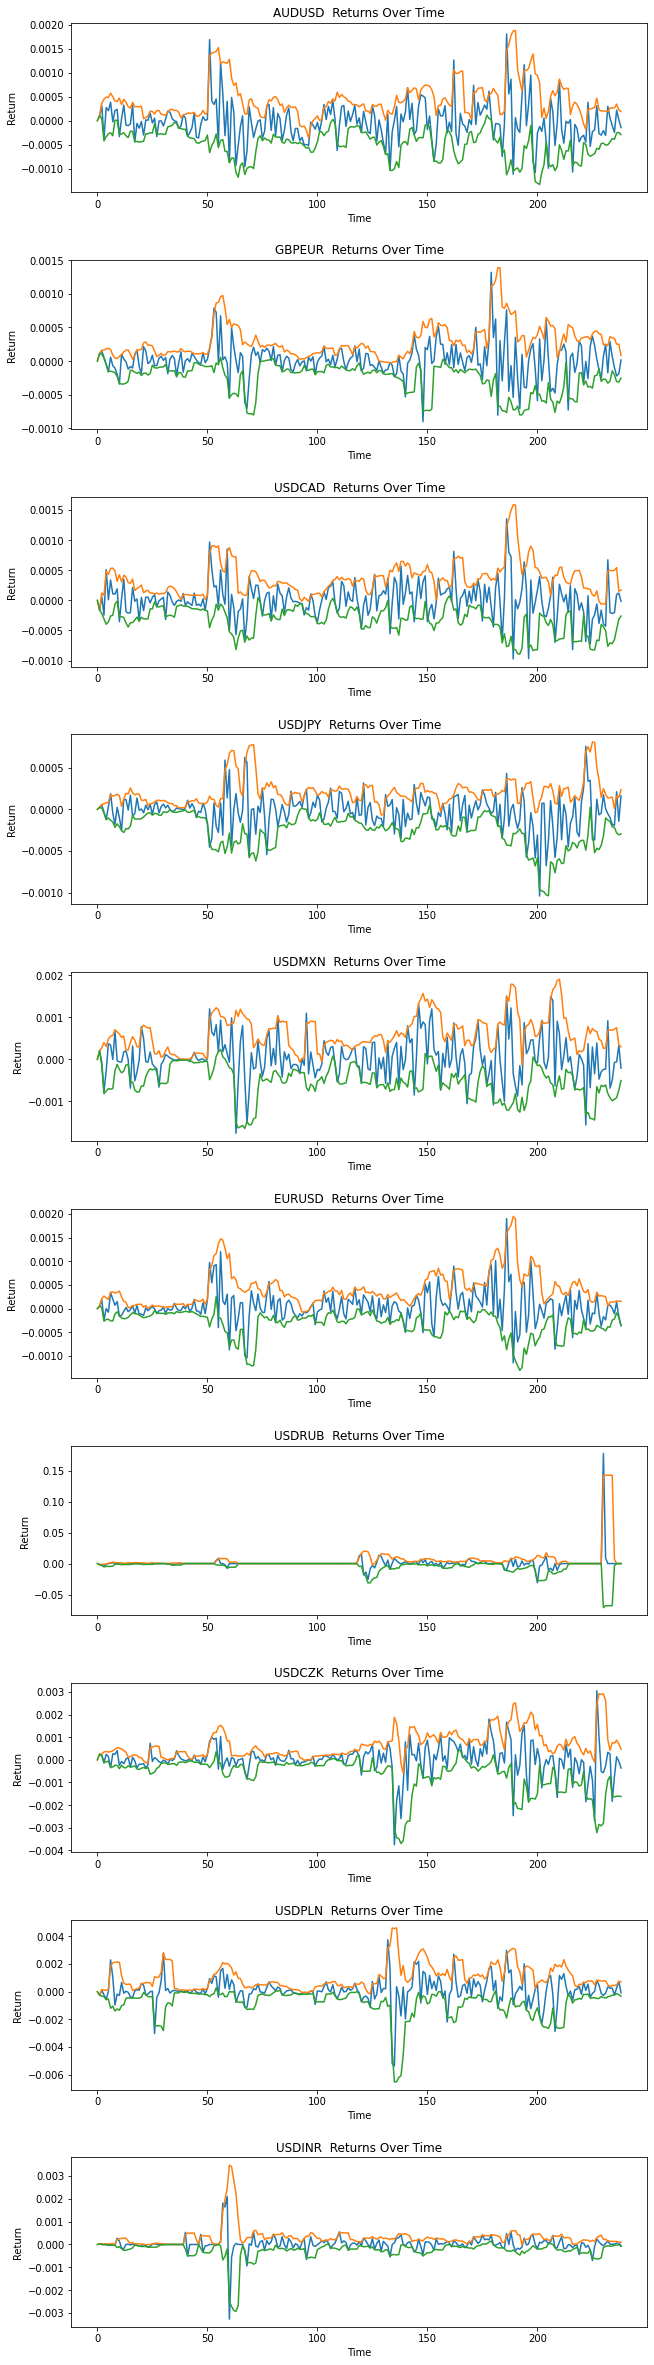

In [31]:
# This section plots the historical returns with their corressponding bollinger bands. It also
# prints the total profits/losses for each currency pair, and the total across all currency pairs. 

# Create a subplot
fig, axs = plt.subplots(10,figsize=(10,40))
fig.tight_layout()

# Variable to keep track of the total profit across currency pairs. 
tot_profit = 0

# Loop through the currency pairs
for ind, currency in enumerate(currency_pairs):
    
    from_ = currency[0]
    to = currency[1]
    
    # The sublists in the following list represent each of the following:
    # hist_return, avg_return, std_return, avg_of_std_return, upper bollinger, lower bollinger
    returns_array = [[],[],[],[],[],[]]
    
    # Extract the data from the classes and put it into a single list for plotting
    for row in currency[2]:
        returns_array[0].append(row.hist_return)
        try:
            returns_array[1].append(row.avg_return)
        except:
            returns_array[1].append(0)
        try:
            returns_array[2].append(row.std_return)
        except:
            returns_array[2].append(0)
        try:
            returns_array[3].append(row.avg_of_std_return)
        except:
            returns_array[3].append(0)
        try:
            returns_array[4].append(row.avg_return + (1.5 * row.std_return))
        except:
            returns_array[4].append(0)
        try:
            returns_array[5].append(row.avg_return - (1.5 * row.std_return))
        except:
            returns_array[5].append(0)
            
    print("The profit/losses for "+from_+to+" calculated with numpy is: %f" % (currency[3].amount -1))
    tot_profit += currency[3].amount - 1
    
    # Plot the line graphs with bollinger bands using the propper formatting
    axs[ind].plot(range(0,len(returns_array[0])),returns_array[0]) # plot the historical returns
    axs[ind].plot(range(0,len(returns_array[4])),returns_array[4]) # plot the upper bollinger band for returns
    axs[ind].plot(range(0,len(returns_array[5])),returns_array[5]) # plot the lower bollinger band for returns
    axs[ind].set(xlabel='Time',ylabel='Return')
    axs[ind].set_title(from_+to+'  Returns Over Time')
    
# Extra formatting to make sure the axis labels do not overlap the titles
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

print("Total profit across currencies is: %f" % tot_profit)